In [146]:
# import relevant libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import csv
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import collections

## Reading NYC MTA dataset

In [147]:
def read(file):
    return pd.read_csv(file)

In [148]:
mta_data = read('turnstile_190302.txt')
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292


**Will only use 100 rows in the dataset**

In [149]:
#mta_data = mta_data.sample(100)
print("Shape: ", mta_data.shape)

Shape:  (203189, 11)


In [150]:
#Standardazing dataset columns
mta_data.columns = mta_data.columns.str.strip().str.lower().str.replace('/','_')
mta_data.columns

Index(['c_a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time',
       'desc', 'entries', 'exits'],
      dtype='object')

In [151]:
mta_data.head()

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292


## Challenge 1
* Open up a new IPython notebook
* Download a few MTA turnstile data files
* Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION). These are the first four columns. The value for this key should be a list of lists. Each list in the list is the rest of the columns in a row. For example, one key-value pair should look like:

{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ ['NQR456', 'BMT', '01/03/2015', '03:00:00', 'REGULAR', '0004945474', '0001675324'], ['NQR456', 'BMT', '01/03/2015', '07:00:00', 'REGULAR', '0004945478', '0001675333'], ['NQR456', 'BMT', '01/03/2015', '11:00:00', 'REGULAR', '0004945515', '0001675364'], ... ] }

In [152]:
#Dictionary function turns dataframe into a dictionary with tuple keys and value list of lists
def dictionary(data):
    diction = collections.defaultdict(list)
    for idx, row in data.iterrows():
        key = tuple(row[0:4])
        value = row[4:].tolist()
        diction[key].append(value)
    return diction

In [154]:
dictionary = dictionary(mta_data)
#dictionary

## Challenge 2
* Let's turn this into a time series.

For each key (basically the control area, unit, device address and station of a specific turnstile), have a list again, but let the list be comprised of just the point in time and the count of entries.

This basically means keeping only the date, time, and entries fields in each list. You can convert the date and time into datetime objects -- That is a python class that represents a point in time. You can combine the date and time fields into a string and use the dateutil module to convert it into a datetime object. For an example check this StackOverflow question.

Your new dict should look something like


{ ('A002','R051','02-00-00','LEXINGTON AVE'): [ [datetime.datetime(2013, 3, 2, 3, 0), 3788], [datetime.datetime(2013, 3, 2, 7, 0), 2585], [datetime.datetime(2013, 3, 2, 12, 0), 10653], [datetime.datetime(2013, 3, 2, 17, 0), 11016], [datetime.datetime(2013, 3, 2, 23, 0), 10666], [datetime.datetime(2013, 3, 3, 3, 0), 10814], [datetime.datetime(2013, 3, 3, 7, 0), 10229], ... ], .... }

In [156]:
def dict_date(dictionary):
    dictionary["date_time"] = pd.to_datetime(dictionary["date"] + dictionary["time"], format='%m/%d/%Y%H:%M:%S')
    data = { key: [[pd.to_datetime(date+time, format='%m/%d/%Y%H:%M:%S'), entry] 
                   for _, _, date, time, _, entry, _ in value]
            for key, value in dictionary.items()
           }
    return data

In [157]:
date_dict = dict_date(dictionary)
#date_dict

## Challenge 3
* These counts are for every n hours. (What is n?) We want total daily entries.

Now make it that we again have the same keys, but now we have a single value for a single day, which is the total number of passengers that entered through this turnstile on this day.

In [158]:
def daily_total(my_dictionary):
    result = dict()
    
    ## Get set of dates for turnstile file from first entry    ## This is unordered
    dates = {datetime.date() for datetime, entry in list(my_dictionary.values())[0]}
    
    ## loop through each turnstile key and data
    for turnstile_key, turnstile_data in my_dictionary.items():
        result_list = list()
        
        ## loop through each date
        for date in dates:
            tomorrows_date = date + timedelta(days = 1)
            todays_entries = [entry for day, entry in turnstile_data if day.date() == date]
            
            ## Check if there's a tomorrow. If tomorrow doesn't exist, just throw back a 0
            try:
                if tomorrows_date in dates:
                    tomorrows_entries = [entry for day, entry in turnstile_data if day.date() == tomorrows_date]
                    result_list.append([date, min(tomorrows_entries) - min(todays_entries)])
                else:
                    result_list.append([date, max(todays_entries)-min(todays_entries)])
            except:
                result_list.append([date, 0])
                
        ## Add this result to the result dictionary
        result[turnstile_key] = result_list    
    return result

In [159]:
daily = daily_total(date_dict)
#daily

## Challenge 4

We will plot the daily time series for a turnstile.

In ipython notebook, add this to the beginning of your next cell:

```Python
%matplotlib inline
```

This will make your matplotlib graphs integrate nicely with the notebook. To plot the time series, import matplotlib with

```Python
import matplotlib.pyplot as plt
```

Take the list of [(date1, count1), (date2, count2), ...], for the turnstile and turn it into two lists: dates and counts. This should plot it:
```Python
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
```

In [160]:
def plot_turnstile(dictionary, key):
    turnstile_data = sorted(dictionary[key])
    
    dates = [x[0] for x in turnstile_data]
    counts = [x[1] for x in turnstile_data]

    plt.figure(figsize=(16,8))
    
    plt.plot(dates, counts)

Text(0, 0.5, 'Number of passengers')

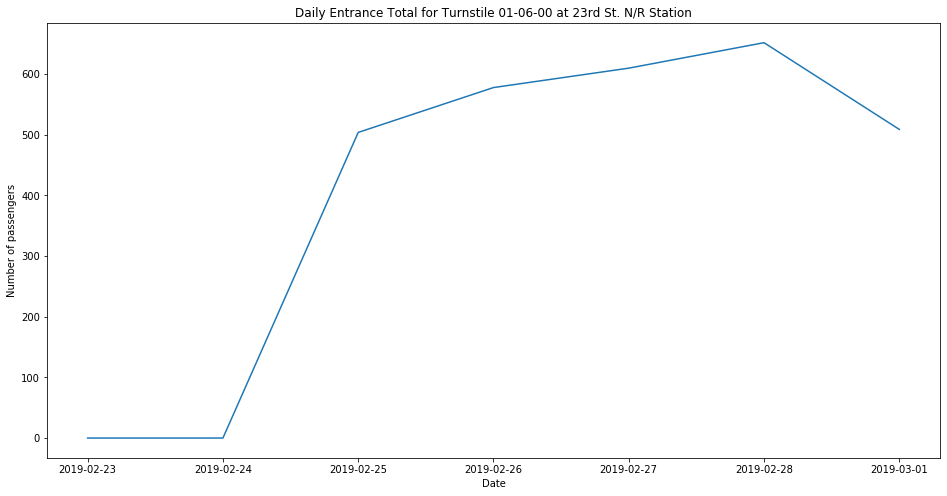

In [161]:
# 'R242A', 'R049', '02-03-02', '51 ST' turnstile
plot_turnstile(daily, ('R242A', 'R049', '02-03-02', '51 ST'))
plt.title('Daily Entrance Total for Turnstile 01-06-00 at 23rd St. N/R Station')
plt.xlabel('Date')
plt.ylabel('Number of passengers')

## Challenge 5

* So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

## Challenge 6

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [162]:
def station_total(dictionary):
    station_dict = collections.defaultdict(list)

    ## Combine all stations in a dictionary
    for index, turnstile_data in dictionary.items():
#         print index, turnstile_data
        
        ## Sum up the total of entries across turnstiles by adding it to a temporary dictionary.
        turnstile_total = dict()
        for date, entry in turnstile_data:
            if date not in turnstile_total:
                turnstile_total[date] = entry
            else:
                turnstile_total[date] += entry

        station_dict[ (index[0], index[1], index[3]) ] = [[date, entry] for date, entry in turnstile_total.items()]

    return dict(station_dict)

In [163]:
station_total = station_total(daily)

## Challenge 7

Plot the time series for a station.

Text(0, 0.5, 'Number of passengers')

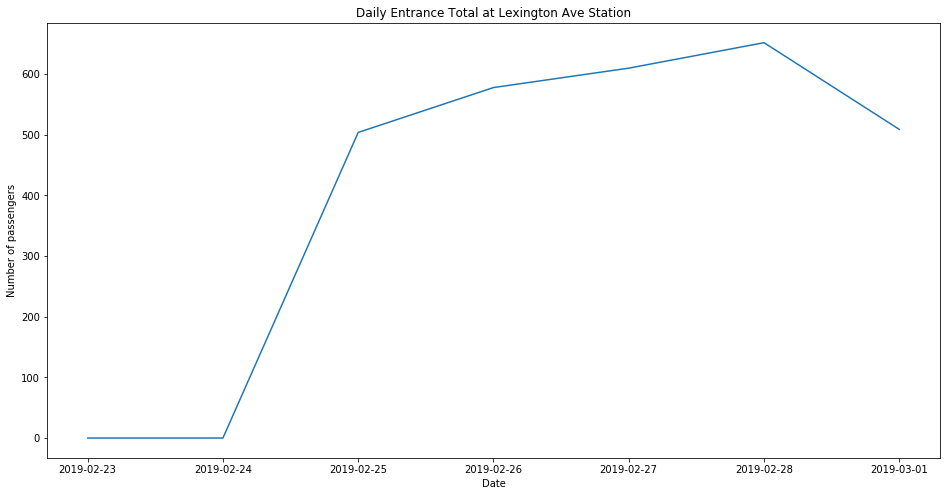

In [164]:
plot_turnstile(station_total, ('R242A', 'R049', '51 ST'))
plt.title('Daily Entrance Total at Lexington Ave Station')
plt.xlabel('Date')
plt.ylabel('Number of passengers')

## Challenge 8

* Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

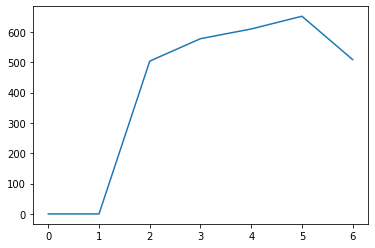

In [165]:
station = ('R242A', 'R049', '51 ST')
week1 = [entry for date, entry in sorted(station_total[station])]

plt.plot(week1)

## Challenge 9

* Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [155]:
files = ["turnstile_190302.txt", "turnstile_190309.txt", "turnstile_190316.txt", "turnstile_190323.txt"]

In [174]:
def plot_weekly(station, file_list):

    plt.figure(figsize=(16,8))
    
    for file in file_list:
        raw = read(file)
        diction = dictionary(raw)
        datetime_dict = dict_date(diction)
        daily_total = daily_total(datetime_dict)
        station_total = station_total(daily_total)
        
        week = [entry for date, entry in sorted(station_total[station])]
        plt.plot(week)
    plt.show()

In [175]:
plot_weekly(station, files)

TypeError: 'collections.defaultdict' object is not callable

<Figure size 1152x576 with 0 Axes>

## Challenge 10

* Make a single list of these total ridership values and plot it with

```Python
plt.hist(total_ridership_counts)
```

to get an idea about the distribution of total ridership among different stations.

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.

*Additional Hint:*

If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,..., so you can do

```Python
indices = range(len(total_ridership_values))
plt.bar(indices, total_ridership_values)
```